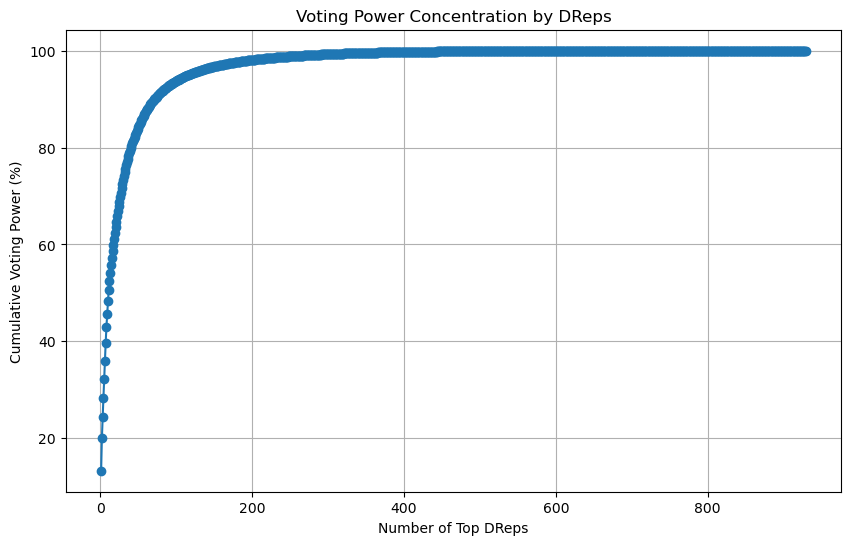

In [13]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime

url = "https://adastat.net/api/rest/v1/dreps.json?rows=all&sort=live_stake&dir=desc&limit=1000&page=1&currency=usd"
response = requests.get(url)

if response.status_code != 200:
    raise Exception(f"Failed to fetch data. HTTP {response.status_code}")

data = response.json()

# Extract rows into DataFrame
df = pd.DataFrame(data["rows"])

# EXCLUDE drep_always_abstain and drep_always_no_confidence
df = df[df['bech32'] != 'drep_always_abstain'].copy()
df = df[df['bech32'] != 'drep_always_no_confidence'].copy()

# Clean and convert live_stake to numeric
df['live_stake'] = pd.to_numeric(df['live_stake'], errors='coerce').fillna(0)

# Sort by stake descending
df_sorted = df.sort_values('live_stake', ascending=False).reset_index(drop=True)

# Compute cumulative % of voting power
df_sorted['cumulative_stake'] = df_sorted['live_stake'].cumsum()
df_sorted['cumulative_pct'] = df_sorted['cumulative_stake'] / df_sorted['live_stake'].sum() * 100

# Plot
plt.figure(figsize=(10,6))
plt.plot(range(1, len(df_sorted)+1), df_sorted['cumulative_pct'], marker='o')
plt.xlabel('Number of Top DReps')
plt.ylabel('Cumulative Voting Power (%)')
plt.title('Voting Power Concentration by DReps')
plt.grid(True)
plt.show()


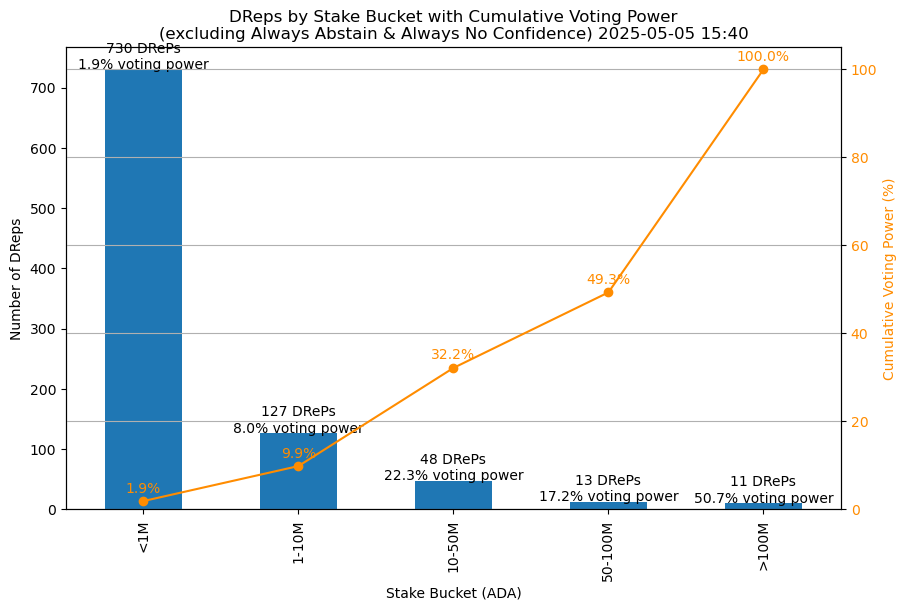

In [20]:
# Convert live_stake to ADA
df['live_stake_ada'] = df['live_stake'] / 1e6

# Define stake buckets
bins = [0, 1e6, 10e6, 50e6, 100e6, float('inf')]
labels = ['<1M', '1-10M', '10-50M', '50-100M', '>100M']

df['stake_bucket'] = pd.cut(df['live_stake_ada'], bins=bins, labels=labels, right=False)
#print(df[['bech32', 'live_stake_ada', 'stake_bucket']])

# Count DReps per bucket
bucket_counts = df['stake_bucket'].value_counts().sort_index()

# Total stake per bucket
bucket_stake = df.groupby('stake_bucket', observed=True)['live_stake'].sum()
bucket_stake_ada = bucket_stake / 1e6

# % and cumulative %
bucket_pct = bucket_stake_ada / bucket_stake_ada.sum() * 100
bucket_cum_pct = bucket_pct.cumsum()

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(10,6))

# Query date
query_date = datetime.now().strftime("%Y-%m-%d %H:%M")

# Bar chart: number of DReps
bucket_counts.plot(kind='bar', ax=ax1)
ax1.set_xlabel('Stake Bucket (ADA)')
ax1.set_ylabel('Number of DReps')
ax1.tick_params(axis='y')
ax1.set_title(f'DReps by Stake Bucket with Cumulative Voting Power\n(excluding Always Abstain & Always No Confidence) {query_date}')

# Add counts and % voting power labels above bars
for i, (count, pct) in enumerate(zip(bucket_counts, bucket_pct)):
    label = f"{int(count)} dreps, {pct:.1f}%"
    ax1.text(i, count + 1, label, ha='center')

# Line chart: cumulative voting power %
ax2 = ax1.twinx()
color_line = 'darkorange'
ax2.plot(range(len(bucket_cum_pct)), bucket_cum_pct, color=color_line, marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Voting Power (%)', color=color_line)
ax2.tick_params(axis='y', labelcolor=color_line)
ax2.set_ylim(0, 105)

# Add % labels above line points
for i, pct in enumerate(bucket_cum_pct):
    ax2.text(i, pct + 2, f"{pct:.1f}%", ha='center', color=color_line)

plt.grid(axis='y')
plt.show()

